In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.applications import EfficientNetB0
from helper_functions import *
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard, CSVLogger

import datetime
import os

c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
gpus = tf.config.list_physical_devices('GPU')
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
tf.config.experimental.get_device_details(gpus[0])

{'device_name': 'NVIDIA GeForce RTX 5070 Ti', 'compute_capability': (12, 0)}

In [4]:
(train_data, test_data), ds_info = tfds.load(name="food101",
                                             split=["train", "validation"],
                                             shuffle_files=False,
                                             as_supervised=True,
                                             with_info=True)

In [5]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
})

In [6]:
class_names = ds_info.features['label'].names
class_names

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheesecake',
 'cheese_plate',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

In [7]:
train_data = train_data.map(image_preprocessing, num_parallel_calls=tf.data.AUTOTUNE)  # Apply preprocessing with parallelism
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)  # Shuffle, batch, and prefetch

test_data = test_data.map(image_preprocessing, num_parallel_calls=tf.data.AUTOTUNE)  # Apply preprocessing with parallelism
test_data = test_data.batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)  # Batch and prefetch

In [8]:
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer")
base_model = EfficientNetB0(include_top=False)
# Manually modify Conv2D and DepthwiseConv2D layers to include L2 regularization
for layer in base_model.layers:
    if isinstance(layer, (tf.keras.layers.Conv2D, tf.keras.layers.DepthwiseConv2D)):
        layer.kernel_regularizer = tf.keras.regularizers.l2(0.001)

x = base_model(inputs)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
x = tf.keras.layers.Dropout(0.3, name='dropout_layer')(x)
x = tf.keras.layers.Dense(101, kernel_regularizer=tf.keras.regularizers.l2(0.001), name='logits')(x)
outputs = tf.keras.layers.Activation('softmax', name='softmax')(x)

model = tf.keras.Model(inputs, outputs, name="Food_Vision_Big")

model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=["accuracy"])

model.summary()

Model: "Food_Vision_Big"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 dropout_layer (Dropout)     (None, 1280)              0         
                                                                 
 logits (Dense)              (None, 101)               129381    
                                                                 
 softmax (Activation)        (None, 101)               0         
                                                   

In [9]:
for layer in model.layers:
    print(layer.name, layer.trainable, layer.dtype, layer.compute_dtype)

input_layer True float32 float32
efficientnetb0 True float32 float32
global_average_pooling_layer True float32 float32
dropout_layer True float32 float32
logits True float32 float32
softmax True float32 float32


In [10]:
for layer in model.layers[1].layers:
    if isinstance(layer, (tf.keras.layers.Conv2D, tf.keras.layers.DepthwiseConv2D)):
        print(layer.name, layer.kernel_regularizer, layer.kernel_regularizer.l2)

stem_conv <keras.regularizers.L2 object at 0x000001EBB650FDC0> 0.001
block1a_dwconv <keras.regularizers.L2 object at 0x000001EBB6524820> 0.001
block1a_se_reduce <keras.regularizers.L2 object at 0x000001EE2DEA6680> 0.001
block1a_se_expand <keras.regularizers.L2 object at 0x000001EE2DF1F910> 0.001
block1a_project_conv <keras.regularizers.L2 object at 0x000001EE2DF1F640> 0.001
block2a_expand_conv <keras.regularizers.L2 object at 0x000001EE2DF1FA30> 0.001
block2a_dwconv <keras.regularizers.L2 object at 0x000001EE2DF1FAC0> 0.001
block2a_se_reduce <keras.regularizers.L2 object at 0x000001EE2DF1FB50> 0.001
block2a_se_expand <keras.regularizers.L2 object at 0x000001EE2DF1FBE0> 0.001
block2a_project_conv <keras.regularizers.L2 object at 0x000001EE2DF1FC70> 0.001
block2b_expand_conv <keras.regularizers.L2 object at 0x000001EE2DF1FD00> 0.001
block2b_dwconv <keras.regularizers.L2 object at 0x000001EE2DF1FD90> 0.001
block2b_se_reduce <keras.regularizers.L2 object at 0x000001EE2DF1FE20> 0.001
block2

In [11]:
final_model_dir = "./final_model"

os.makedirs(f"{final_model_dir}/checkpoints", exist_ok=True)
os.makedirs(f"{final_model_dir}/logs", exist_ok=True)
os.makedirs(f"{final_model_dir}/history", exist_ok=True)

In [12]:
checkpoint = ModelCheckpoint(
        filepath=f"{final_model_dir}/checkpoints/Food_Vision_Final_epoch{{epoch:02d}}.weights.h5",
        monitor="val_accuracy",
        save_best_only=False,
        save_weights_only=True,
        save_freq="epoch",
        verbose=1
    )

In [13]:
tensorboard = TensorBoard( log_dir=f"{final_model_dir}/logs/{datetime.datetime.now().strftime('%Y%m%d-%H%M%S')}")

In [14]:
reduce_lr = ReduceLROnPlateau(
        monitor="val_accuracy",
        factor=0.2,
        patience=0,
        verbose=1,
        min_lr=1e-7,
    )

In [15]:
early_stopping = EarlyStopping(
        monitor="val_accuracy",
        patience=3,
        verbose=1
    )

In [16]:
csv_logger = CSVLogger(f"{final_model_dir}/history/Food_Vision_Final.csv", append=True)

In [17]:
history = model.fit(train_data,
                    epochs=50,
                    steps_per_epoch=len(train_data),
                    validation_data=test_data,
                    validation_steps=int(0.15*len(test_data)),
                    callbacks=[checkpoint, tensorboard, reduce_lr, early_stopping, csv_logger],
                          )

Epoch 1/50
2367/2368 [============================>.] - ETA: 0s - loss: 1.9618 - accuracy: 0.5562
Epoch 1: saving model to ./final_model/checkpoints\Food_Vision_Final_epoch01.weights.h5
2368/2368 [==============================] - 336s 81ms/step - loss: 1.9620 - accuracy: 0.5562 - val_loss: 1.3269 - val_accuracy: 0.6923 - lr: 0.0010
Epoch 2/50
2367/2368 [============================>.] - ETA: 0s - loss: 1.3607 - accuracy: 0.6895
Epoch 2: saving model to ./final_model/checkpoints\Food_Vision_Final_epoch02.weights.h5
2368/2368 [==============================] - 191s 81ms/step - loss: 1.3608 - accuracy: 0.6895 - val_loss: 1.1901 - val_accuracy: 0.7267 - lr: 0.0010
Epoch 3/50
2367/2368 [============================>.] - ETA: 0s - loss: 1.1634 - accuracy: 0.7335
Epoch 3: saving model to ./final_model/checkpoints\Food_Vision_Final_epoch03.weights.h5
2368/2368 [==============================] - 191s 81ms/step - loss: 1.1634 - accuracy: 0.7335 - val_loss: 1.1526 - val_accuracy: 0.7418 - lr: 0.

In [18]:
file_name = f"{final_model_dir}/history/Food_Vision_Final.json"

history_data = {
    key: [float(value) if isinstance(value, (np.floating, np.float32, np.float64)) else int(value) if isinstance(value, (np.integer, np.int32, np.int64)) else value
            for value in values]
    for key, values in history.history.items()
}

with open(file_name, "w") as f:
    json.dump(history_data, f, indent=4)

print(f"Training history saved to {file_name}")

Training history saved to ./final_model/history/Food_Vision_Final.json


In [19]:
model.evaluate(test_data)

790/790 [==============================] - 15s 19ms/step - loss: 0.7361 - accuracy: 0.8400


[0.7361051440238953, 0.8400396108627319]

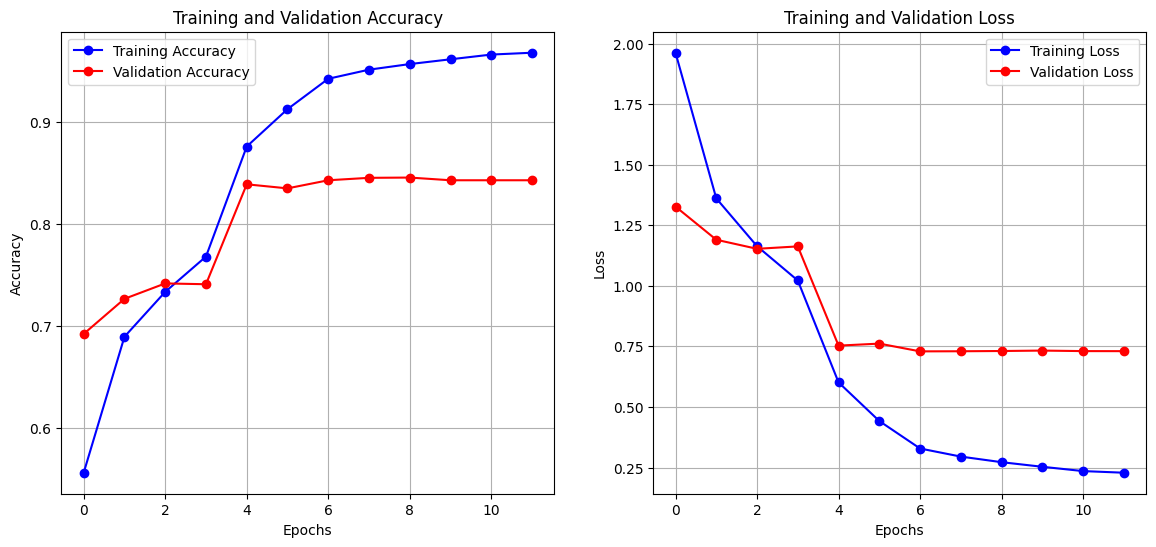

In [20]:
plot_history(history)

In [24]:
model.get_weights()

[array([0.485, 0.456, 0.406], dtype=float32),
 array([0.229, 0.224, 0.225], dtype=float32),
 0,
 array([[[[ 1.25542611e-01,  8.69908869e-01, -9.74949002e-01,
            9.28969085e-01,  1.29158199e-01,  4.92514595e-02,
            8.86926241e-03,  1.01189330e-01, -7.17071712e-01,
           -2.58868903e-01,  2.08738402e-01, -5.70219606e-02,
           -3.98024708e-01, -1.07543039e+00, -1.25888914e-01,
           -7.82102525e-01,  2.76172310e-02,  2.24037722e-01,
            7.16624856e-01,  9.84899327e-02,  7.07545951e-02,
            8.09047639e-01,  1.94697514e-01,  4.85000126e-02,
            1.61440775e-01, -6.39987826e-01,  2.18497857e-01,
            2.24619657e-02,  4.54162769e-02, -9.28719267e-02,
            4.26160134e-02, -1.15410663e-01],
          [ 2.56097559e-02,  1.61269832e+00, -1.81463301e+00,
            6.42301381e-01,  2.85787452e-02,  1.09796084e-01,
           -1.18720524e-01, -3.84537309e-01,  6.14391863e-01,
           -3.34226429e-01,  1.61813498e-02, -1.1551

In [25]:
model.load_weights("./final_model/checkpoints/Food_Vision_Final_epoch05.weights.h5")

In [26]:
model.get_weights()

[array([0.485, 0.456, 0.406], dtype=float32),
 array([0.229, 0.224, 0.225], dtype=float32),
 0,
 array([[[[ 1.27760142e-01,  8.66375625e-01, -9.71944213e-01,
            9.15093958e-01,  1.31729439e-01,  4.41481359e-02,
            7.38121103e-03,  9.47161987e-02, -7.21173286e-01,
           -2.58921534e-01,  2.07443148e-01, -6.45006076e-02,
           -3.94391567e-01, -1.07733190e+00, -1.26957417e-01,
           -7.78379142e-01,  2.79489625e-02,  2.26426288e-01,
            7.13784516e-01,  9.87968966e-02,  7.03217536e-02,
            8.14453602e-01,  1.98947147e-01,  4.71010096e-02,
            1.54525399e-01, -6.40210569e-01,  2.16530740e-01,
            2.84706447e-02,  4.43132520e-02, -1.00473940e-01,
            2.39846371e-02, -1.20971881e-01],
          [ 3.19993161e-02,  1.61292863e+00, -1.81304693e+00,
            6.49631560e-01,  2.77283099e-02,  1.02656089e-01,
           -1.27833977e-01, -3.89291257e-01,  6.10571802e-01,
           -3.34527820e-01,  2.13055462e-02, -1.2217

In [27]:
model.evaluate(test_data)

790/790 [==============================] - 15s 19ms/step - loss: 0.7605 - accuracy: 0.8337


[0.7604951858520508, 0.8337425589561462]

# Final Model Training & Deployment Strategy

The final model intended for deployment was trained in this notebook. It was set to train for **50 epochs**, but the **EarlyStopping** callback triggered at **epoch 12**, preventing unnecessary overfitting.

## Best Weights Selection
After analyzing the training process, the best-performing set of weights was achieved at **epoch 5**, where:  
- **Training Accuracy:** `0.8760`  
- **Validation Accuracy:** `0.8390`  

This set of weights demonstrated **lower overfitting** compared to later epochs, making it the optimal choice for deployment.

## Deployment Approach
Instead of deploying the entire trained model, we will **only deploy the weights**. The model will be **reconstructed** in the deployment environment, and these weights will be **loaded** to make predictions dynamically whenever needed.

## Reason for Deploying Weights Instead of the Full Model
Attempts to save the trained model encountered a **TensorFlow serialization error**, specifically an issue where TensorFlow could not **convert eager tensors** due to modifications in the EfficientNetB0 backbone (e.g., kernel regularization). As a **temporary solution**, we will deploy only the weights, ensuring the web application can still function properly.

Future commits will aim to **resolve the serialization issue** so that the full model can be deployed directly.
